# Synthetic Data Generation Baseline

In [1]:
import os, sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import pickle
import sklearn
import tqdm.notebook as tqdm

from sklearn.model_selection import train_test_split
sns.set_theme()
sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

from lib.vae_models import VAE, CVAE
import lib.datasets as datasets
import lib.utils as utils

#### Import Data

In [3]:
DATASET_NAME = 'goi4_dp_small_2yrs_inpost'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 1011780 consumption profiles from 730 dates and 1386 users


In [5]:
date_dict = np.load(f'../data/{DATASET_NAME}/encode_dict.npy', allow_pickle=True).item()["date_dict"]
date_dict_inv = {v: k for k, v in date_dict.items()}

In [6]:
if not os.path.exists(f'../data/{DATASET_NAME}/raw_dates.npy'):
    raw_dates = np.array([datetime.datetime.strptime(date_dict_inv[d], '%Y-%m-%d') for d in dates])
    np.save(f'../data/{DATASET_NAME}/raw_dates.npy', raw_dates)
else:
    raw_dates = np.load(f'../data/{DATASET_NAME}/raw_dates.npy', allow_pickle=True)

In [7]:
metadata = pd.read_csv(f'../data/{DATASET_NAME}/metadata.csv')

In [8]:
unique_provinces = metadata.province.unique()
print(f'Loaded metadata for {len(unique_provinces)} provinces')
print(f"Uniqe provinces are: {unique_provinces}")

Loaded metadata for 29 provinces
Uniqe provinces are: ['Bizkaia' 'Gipuzkoa' 'Navarra' 'La Rioja' 'Madrid' 'Palencia' 'Cantabria'
 'Araba/Alava' 'Valencia/Valencia' 'Burgos' 'Cuenca' 'Coruna A' 'Murcia'
 'Salamanca' 'Cadiz' 'Tarragona' 'Jaen' 'Huesca' 'Cordoba' 'Soria'
 'Ourense' 'Zaragoza' 'Barcelona' 'Guadalajara' 'Caceres'
 'Alicante/Alacant' 'Lleida' 'Avila' 'Zamora']


### Prepare Conditions

In [9]:
months = np.array([d.month for d in raw_dates])
weekdays = np.array([d.weekday() for d in raw_dates])
is_weekend = np.array([int(d.weekday() >= 5) for d in raw_dates])

In [10]:
df_temp = pd.read_csv(f'../data/{DATASET_NAME}/spain_temp_daily.csv')
df_temp.index = pd.to_datetime(df_temp['date'])
df_temp.drop(columns='date', inplace=True)
df_temp = df_temp.loc[raw_dates]

In [11]:
df_prec = pd.read_csv(f'../data/{DATASET_NAME}/spain_prec_daily.csv')
df_prec.index = pd.to_datetime(df_prec['date'])
df_prec.drop(columns='date', inplace=True)
df_prec = df_prec.loc[raw_dates]
df_prec = df_prec.sort_values(by='prec_total')

In [12]:
condition_kwargs = {}

In [13]:
ADD_MONTHS = True
ADD_WEEKDAYS = False
ADD_IS_WEEKEND = True
ADD_TEMPERATURE_MIN = False
ADD_TEMPERATURE_MAXDELTA = False
ADD_PRECIPITATION_LEVEL = False

condition_kwargs["tags"], condition_kwargs["types"], condition_kwargs["supports"], condition_set  = [], [], [], {}
if ADD_MONTHS: 
    condition_kwargs["tags"].append("months")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(months).tolist())
    condition_set["months"] = months
if ADD_WEEKDAYS: 
    condition_kwargs["tags"].append("weekdays")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(weekdays).tolist())
    condition_set["weekdays"] = weekdays
if ADD_IS_WEEKEND:
    condition_kwargs["tags"].append("is_weekend")
    condition_kwargs["types"].append("cat")
    condition_kwargs["supports"].append([0, 1])
    condition_set["is_weekend"] = is_weekend
if ADD_TEMPERATURE_MIN:
    condition_kwargs["tags"].append("temp_min")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_min"] = df_temp[condition_kwargs["tags"][-1]].values
if ADD_TEMPERATURE_MAXDELTA:
    condition_kwargs["tags"].append("temp_max_delta")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_max_delta"] = df_temp[condition_kwargs["tags"][-1]].values
if ADD_PRECIPITATION_LEVEL:
    condition_kwargs["tags"].append("precipitation_level")
    condition_kwargs["types"].append("ord")
    condition_kwargs["supports"].append(np.unique(df_prec["label"]).tolist())
    condition_set["precipitation_level"] = df_prec["label"].values


In [14]:
conditioner = datasets.Conditioner(**condition_kwargs, condition_set=condition_set)

#### Set Resolution

In [15]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = np.reshape(data, (-1, 24))
    X = np.reshape(np.concatenate([X[:,6:], X[:,:6]], axis=-1), (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)    #circle shift the last dimension of X
else:
    X = np.reshape(data, (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)

# condition_set = np.reshape(condition_set, (num_users, num_days, -1))
condition_set = {k: np.reshape(v, (num_users, num_days, -1)) for k, v in condition_set.items()}

#### Clean Data

In [16]:
nonzero_user_mask = np.sum(np.all(X == 0, axis=2), axis=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = np.sum(np.any(X < 0, axis=2), axis=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask
X = X[user_mask]
condition_set = {k: v[user_mask] for k, v in condition_set.items()}

Removing 4 users with all-zero consumption profiles
Removing 18 users with any-negative consumption profiles


#### Ampute the Dataset

In [17]:
np.random.seed(RANDOM_SEED)
n, a, b = num_days, 0.85, 10.0
# n, a, b = num_days, 1.0, 1.0
missing_days = np.random.binomial(n, p=np.random.beta(a, b, size=X.shape[0]), size=X.shape[0])
print(f"Mean of missing days: {n*a/(a+b):.2f}")

Mean of missing days: 57.19


In [18]:
X_missing = X.copy().astype(float)
condition_missing = {k: v.copy().astype(float) for k, v in condition_set.items()}

for user in range(X.shape[0]): 
    X_missing[user, :missing_days[user]] = np.nan
    for k in condition_missing.keys():
        condition_missing[k][user, :missing_days[user]] = np.nan

#### Subsample the Dataset

In [19]:
USER_SUBSAMPLE_RATE, DAY_SUBSAMPLE_RATE = 10, 1
X, X_missing = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :], X_missing[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
condition_set = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_set.items()}
condition_missing = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_missing.items()}
num_users, num_days, num_features = X.shape
X_gt_list = [X[user, :missing_days[user]]*1 for user in range(num_users)]
X_gt_condition_list = {k: [v[user, :missing_days[user]]*1 for user in range(num_users)] for k, v in condition_set.items()}

print("{:.<40}{:.>5}".format("Number of (subsampled/filtered) users", num_users))
print("{:.<40}{:.>5}".format("Number of (subsampled) days", num_days))
print("{:.<40}{:.>5}".format("Number of (aggregated) features", num_features))

Number of (subsampled/filtered) users.....137
Number of (subsampled) days...............730
Number of (aggregated) features............24


In [20]:
missing_idx_mat  = np.isnan(X_missing).any(2)
missing_num_labels = {"user": missing_idx_mat.sum(1), "day": missing_idx_mat.sum(0) }

In [21]:
X_missing = X_missing.reshape(-1, num_features)
conditions_missing = {k: v.reshape(-1, v.shape[-1]) for k, v in condition_missing.items()}
missing_idx = np.isnan(X_missing.sum(1))
X_missing = X_missing[~missing_idx]
conditions_missing = {k: v[~missing_idx] for k, v in conditions_missing.items()}

#### Prepare the Training Data with Missing Records

In [22]:
DISCRETE = False

if DISCRETE:
    ## discretize the data
    ... #TODO
else:
    SHIFT = 1.0
    ZERO_ID = -3
    LOG_SPACE = True
    nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_missing)
    X_missing = utils.zero_preserved_log_normalize(X_missing, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

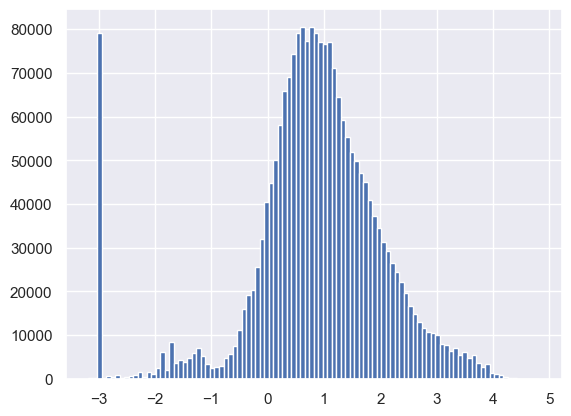

In [23]:
plt.hist(X_missing.flatten(), bins=100)
plt.show()

In [24]:
## split the X_missing and conditions_missing into training and validation sets
VAL_RATIO = 0.2
random_idx = np.random.permutation(len(X_missing))
val_idx = random_idx[:int(len(X_missing)*VAL_RATIO)]
train_idx = random_idx[int(len(X_missing)*VAL_RATIO):]

X_train, X_val = X_missing[train_idx], X_missing[val_idx]
conditions_train = {k: v[train_idx] for k, v in conditions_missing.items()}
conditions_val = {k: v[val_idx] for k, v in conditions_missing.items()}

In [25]:
trainset = datasets.ConditionedDataset(inputs=X_train, conditions=conditions_train, conditioner=conditioner)
valset = datasets.ConditionedDataset(inputs=X_val, conditions=conditions_val, conditioner=conditioner)
print(f"Number of Training Points: {len(trainset)}")
print(f"Number of Validation Points: {len(valset)}")

Number of Training Points: 72875
Number of Validation Points: 18218


### Model

In [26]:
distribution_dict = {"posterior": {"dist_type": "normal",
                                    "learn_sigma": True,
                                    "sigma_lim": 0.01,
                                    "num_neurons": 500,
                                    "num_hidden_layers": 3,
                                    "dropout": True,
                                    "dropout_rate": 0.25,
                                    "batch_normalization": True,
                                    "resnet": True},
                    "likelihood": {"dist_type": "mixed",
                                    "continuous_dist_type": "normal", 
                                    "learn_sigma": True,
                                    "sigma_lim": 0.01,
                                    "sigma_fixed": 0.1,
                                    "num_neurons": 500,
                                    "num_hidden_layers": 3,
                                    "dropout": True,
                                    "dropout_rate": 0.25,
                                    "batch_normalization": True,
                                    "resnet": True}
                    }

In [27]:
model_kwargs = {"latent_dim": 24,
                "condencoding_dim": None,
                "distribution_dict": distribution_dict,
                }

In [28]:
model = CVAE(input_dim=num_features, conditioner=conditioner, **model_kwargs)

### Training

In [29]:
train_kwargs = {
                "lr": 1e-4,
                "beta": 0.1,
                "num_mc_samples": 1,
                "epochs": 10,
                "verbose_freq": 250,
                "tensorboard": True,
                "batch_size": 16,
                "validation_freq": 1000,
                "device": "cpu",
                "tqdm_func": tqdm.tqdm,
                }

In [30]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024, drop_last=False)

In [31]:
model.fit(trainloader=trainloader, valloader=valloader, **train_kwargs)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration in Epoch:   0%|          | 0/4554 [00:00<?, ?it/s]

/home/kbolat/miniconda3/envs/torchenv/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/kbolat/miniconda3/envs/torchenv/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration: 250 -- ELBO=-6.51e+01 / RLL=-4.15e+01 / KL=2.35e+01
Iteration: 500 -- ELBO=-6.73e+01 / RLL=-3.96e+01 / KL=2.77e+01
Iteration: 750 -- ELBO=-5.88e+01 / RLL=-3.14e+01 / KL=2.75e+01
Validation -- ELBO=-4.83e+01 / RLL=-2.81e+01 / KL=2.02e+01
Iteration: 1000 -- ELBO=-5.04e+01 / RLL=-2.58e+01 / KL=2.46e+01
Iteration: 1250 -- ELBO=-4.80e+01 / RLL=-2.39e+01 / KL=2.41e+01
Iteration: 1500 -- ELBO=-4.88e+01 / RLL=-2.62e+01 / KL=2.25e+01
Iteration: 1750 -- ELBO=-5.86e+01 / RLL=-3.66e+01 / KL=2.20e+01
Validation -- ELBO=-4.06e+01 / RLL=-2.43e+01 / KL=1.63e+01
Iteration: 2000 -- ELBO=-5.51e+01 / RLL=-3.32e+01 / KL=2.19e+01
Iteration: 2250 -- ELBO=-4.59e+01 / RLL=-2.46e+01 / KL=2.14e+01
Iteration: 2500 -- ELBO=-4.70e+01 / RLL=-2.68e+01 / KL=2.03e+01
Iteration: 2750 -- ELBO=-4.51e+01 / RLL=-2.36e+01 / KL=2.14e+01
Validation -- ELBO=-4.04e+01 / RLL=-2.21e+01 / KL=1.83e+01
Iteration: 3000 -- ELBO=-6.00e+01 / RLL=-3.83e+01 / KL=2.17e+01
Iteration: 3250 -- ELBO=-4.37e+01 / RLL=-2.51e+01 / KL=1.8

KeyboardInterrupt: 

In [32]:
model.eval()

CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=28, out_features=500, bias=True)
            (1): Softplus(beta=1, threshold=20)
            (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.25, inplace=False)
          )
          (middle_layers): ModuleList(
            (0-2): 3 x Sequential(
              (0): Linear(in_features=500, out_features=500, bias=True)
              (1): Softplus(beta=1, threshold=20)
              (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): Dropout(p=0.25, inplace=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=500, out_features=500, bias=True)
            (1): Softplus(beta=1, threshold=20)
            (2): BatchNorm1d(500,

In [33]:
save_path = model.log_dir
model_name = f'trained_model'
model_path = f'./{save_path}/{model_name}.pt'
torch.save(model.state_dict(), model_path)
print(f'Model saved at {model_path}')

Model saved at ./runs/Apr28_16-29-24_iepg-st-gpu.ewi.tudelft.nl/trained_model.pt


In [34]:
conditioner_path = f'./{save_path}/conditioner.pkl'
with open(conditioner_path, 'wb') as f: pickle.dump(conditioner, f)
print(f'Conditioner saved at {conditioner_path}')

Conditioner saved at ./runs/Apr28_16-29-24_iepg-st-gpu.ewi.tudelft.nl/conditioner.pkl


In [35]:
random_conditions = conditioner.get_random_conditions(1)
print(random_conditions[1])

{'months': array([9]), 'is_weekend': array([0])}


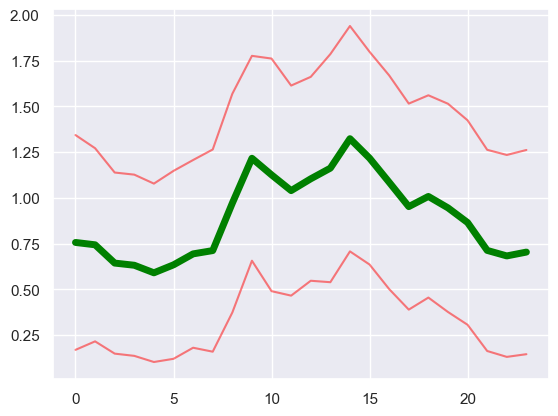

In [41]:
x_sample = model.sample(condition=torch.tensor(random_conditions[0]).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = x_sample["params"]["sigma"].detach()
plt.plot(x_mu.T, lw=5, color='green')
plt.plot((x_mu+x_sigma).T, color='red', alpha=0.5)
plt.plot((x_mu-x_sigma).T, color='red', alpha=0.5)
plt.show()

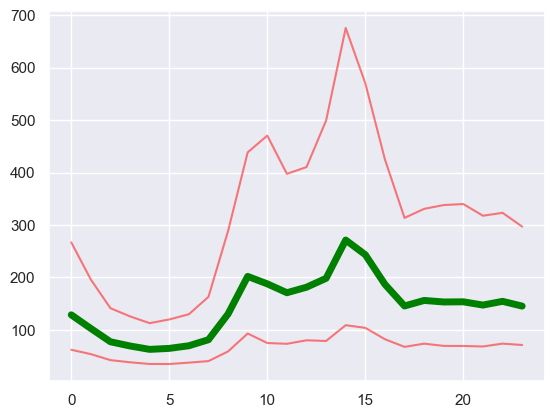

In [42]:
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

plt.plot(x_mu_denorm.T, lw=5, color='green')
plt.plot(x_sigma_upper_denorm.T, color='red', alpha=0.5)
plt.plot(x_sigma_lower_denorm.T, color='red', alpha=0.5)
plt.show()

plt.show()

In [43]:
x, cond_x = trainset.__getitem__(2112)

In [44]:
x_rec, z_rec = model.reconstruct(x.unsqueeze(0), cond_x.unsqueeze(0))

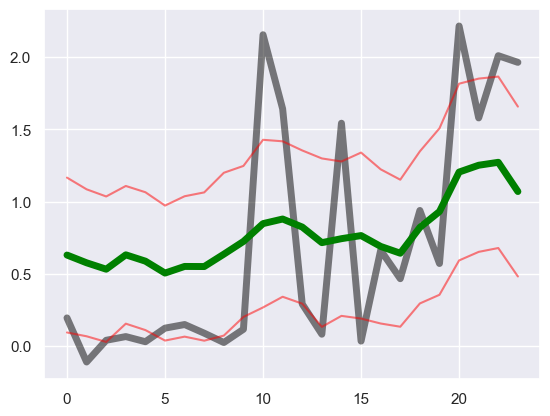

In [45]:
plt.plot(x, lw=5, color='black', alpha=0.5)
plt.plot(x_rec["params"]["mu"][0].T, color='green', lw=5)
plt.plot(x_rec["params"]["mu"][0].T + x_rec["params"]["sigma"][0].T, alpha=0.5, color='red')
plt.plot(x_rec["params"]["mu"][0].T - x_rec["params"]["sigma"][0].T, alpha=0.5, color='red')


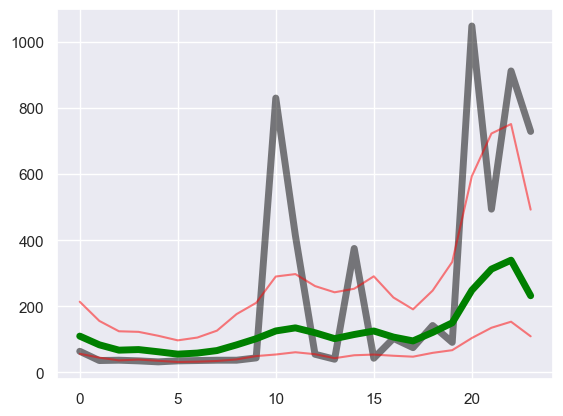

In [46]:
x_denorm = utils.zero_preserved_log_denormalize(x.unsqueeze(0), nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_rec_denorm = utils.zero_preserved_log_denormalize(x_rec["params"]["mu"], nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
X_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(x_rec["params"]["mu"] - x_rec["params"]["sigma"], nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
X_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(x_rec["params"]["mu"] + x_rec["params"]["sigma"], nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
plt.plot(x_denorm[0], lw=5, color='black', alpha = 0.5)
plt.plot(x_rec_denorm[0].T, color='green', lw=5)
plt.plot(X_rec_denorm_sigma_low[0].T, alpha=0.5, color='red')
plt.plot(X_rec_denorm_sigma_high[0].T, alpha=0.5, color='red')
plt.show()